# PatchNet: A Deep Learning Project for Visual Recognition
***Authors: Krisztián Bokor, Ginés Carreto Picón, Marc Johler***

PatchNet describes a deep learning technique for processing visual information consisting of an image that has been split into patches, in order to solve different tasks. In this certain application, we will use this method to approximate the corresponding depth and normal maps of two-dimensional RGB images of a _textureless deformable surface_.

This notebook serves as a demonstration of our implementation of the architecture of the artice: 
_[Patch-Based Reconstruction of a Textureless Deformable 3D Surface from a Single RGB Image](https://ieeexplore.ieee.org/document/9022546)_

We provide code to 

- **create** the model we have used
- **load** its trained weights 
- **evaluate** it on a test set in order to recreate our results
- **visualize** the results

This file is suited for execution on either Google Colab or a local environment.

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

## Preliminaries

### Cloning the source code

The source code of the project is accessible on [Github](https://github.com/Atamarado/DLVR_3DReconstruction). For Google Colab environments, in the following we will clone the `main` branch of the repository.

In [2]:
# FOR COLAB ENVIRONMENT

if IN_COLAB:
  # Clone repo from github
  username = 'Atamarado'
  repository = 'DLVR_3DReconstruction'

  !git clone https://github.com/{username}/{repository}

Cloning into 'DLVR_3DReconstruction'...
remote: Enumerating objects: 1019, done.
remote: Counting objects: 100% (214/214), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 1019 (delta 141), reused 214 (delta 141), pack-reused 805
Receiving objects: 100% (1019/1019), 6.59 MiB | 12.10 MiB/s, done.
Resolving deltas: 100% (619/619), done.


### Acquiring the dataset

We firstly have to acquire the dataset we have used. We have utilized the [Texture-less Deformable Surfaces Dataset](https://www.epfl.ch/labs/cvlab/data/texless-defsurf-data/), with some data preparation applied to it in order to make it compatible with our dataloader.

The prepared dataset can be downloaded from this [link](https://drive.google.com/file/d/1Wg2dB8y98aektVxC70ZPl62QjtSBxiYZ/view?usp=sharing).

- For a Google Colab environment, use the following cell to fetch the dataset from Google Drive, and unzip it in the local storage.
- If using your local environment, unzip the data in the workspace of the repository, into a folder called `data`.

In [3]:
# FOR COLAB ENVIRONMENT
if IN_COLAB:
  # upgrade the Google Drive downloader
  !pip install --upgrade --no-cache-dir gdown

  # download the data to local runtime storage
  !gdown 1Wg2dB8y98aektVxC70ZPl62QjtSBxiYZ

  # Unzip the data
  !7z x '/content/pnData.zip'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1Wg2dB8y98aektVxC70ZPl62QjtSBxiYZ
To: /content/pnData.zip
100% 3.98G/3.98G [00:42<00:00, 93.9MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 3976388571 bytes (3793 MiB)

Extracting archive: /content/pnData.zip
  6% 4096 Open              --
Path = /content/pnData.zip
Type = zip
Physical Size = 3976388571
64-bit = +

  0%      0% 626 - pnData/test/depth_maps/cloth_Ld_bottom_edge_0200.npz

In [4]:
# Set the paths for both training and testing datasets

if IN_COLAB:
  train_path = '/content/pnData/train'
  test_path = '/content/pnData/test'
else:
  # note that the data is expected to be unzipped in the root of the repoository
  train_path = 'data/pnData/train'
  test_path = 'data/pnData/test'

### Acquiring the pretrained weights

We provide the pretrained weights of our baseline model that has been trained for 20 epochs. The weights have been saved at each epoch, and we will provide a way to load them shortly. 

In the case of a Colab environment, run the following code to fetch the weights.

In case of a local machine, download the weights from this [link](https://drive.google.com/file/d/1lgf6r_xr317zEew0VTBkKIBnMP17baPl/view?usp=sharing) and decompress them in the root directory of the repository.

In [5]:
if IN_COLAB:
  # fetch the weights
  !gdown 1lgf6r_xr317zEew0VTBkKIBnMP17baPl

  # decompress them
  !7z x '/content/baseline_fixed_overlap_trained_weights.zip'

  weights_path = '/content/baseline_fixed_overlap_trained_weights'
else:
  weights_path = 'baseline_fixed_overlap_trained_weights'

Downloading...
From: https://drive.google.com/uc?id=1lgf6r_xr317zEew0VTBkKIBnMP17baPl
To: /content/baseline_fixed_overlap_trained_weights.zip
100% 57.2M/57.2M [00:00<00:00, 186MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 57224718 bytes (55 MiB)

Extracting archive: /content/baseline_fixed_overlap_trained_weights.zip
--
Path = /content/baseline_fixed_overlap_trained_weights.zip
Type = zip
Physical Size = 57224718

  0%     22% 32 - baseline_fixed_overlap_trained_we . ch_15_encoder.data-00000-of-00001                                                                               

### Tensorflow version

Bear in mind that this project has been developed with version **2.9.2** of the `tensorflow` package. We recommend installing this distribution of the package if running in a Colab environment.

In [6]:
if IN_COLAB:
  # Install the recommended version of tensorflow
  %pip install tensorflow==2.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Recreating our model

Now that we have all the necessary resources, we can recreate our model.

Firstly, we need to change into the directory of the source files, in the Colab environment.

In [7]:
if IN_COLAB:
  %cd {repository}
%cd src

/content/DLVR_3DReconstruction
/content/DLVR_3DReconstruction/src


Secondly, we need to import the required library components.

Note that as part of our project we have implemented not only the described architecture of Tsoli et al., but also experimented with modifying its encoder achitecture. The first imports are different classes that have the structures described in our report. All of these can be used as an 'implementation' of the 'abstract' `PatchNet` module.

In [8]:
# the different architecture options
from patch.nets.pnBaseline import TfNetwork as baseline
from patch.nets.pnUNet import TfNetwork as unet
from patch.nets.pnInception import TfNetwork as inception

# the abstract tensorflow module
from patch.PatchNet_tf import PatchNet

# the data generator
from DataGenerator import DataGenerator

# different training and testing functions
from Feed_data import train, test, patch_loop_separate_loss, image_loop, patch_loop

if not(IN_COLAB):
  %cd ..

Our first task goal is to recreate the results we have compared with the original authors' implementation. For this, we need to use the following settings and hyperparameters. 

Here we again present one of our adaptations: Tsoli et al. call for patches that have a fixed overlap size on both spatial dimensions of half the corresponding dimension. This means that the images get broken down into 9 patches. This setting is represented in the `fixed_overlaps` parameter.

However, setting this parameter to `False` would mean that the data generator would use our novel idea of patching the image into the least number of patches possible, to reduce redundancy. This would mean each picture is broken down into 4 patches with minimal possible overlap, given the patch size.

For the sake of recereating the baseline model of the inventors, we shall fix the overlaps.

In [9]:
# the size of the patches our images will be broken down into
patch_size = 128

# the minimum number of channels in our convolutional layers
min_channels = 8

# the batch size, meaning 32 images at once, broken down into patches
batch_size = 32

# prompting the data loader to break up our images instead of returning them intact
patching = True

# we do not need training, only the evaluation of our model
validation = True

# we want the entire test set to act as a validation set, 1 -> 100%
train_val_split = 1

# requiring the data generator to create batches of highly redundant patches with fixed overlaps
fixed_overlaps = True

Using these settings we can instantiate our model and data loader. The data loader will use the `test_path` because we want to first recreate our described test results. We want no training to happen with this data, thus we set the `train_val_split` to 1, meaning 100% of the data is used for validation.

In [10]:
# model with the given parameters, and the baseline implementation
patchnet = PatchNet(patch_size, min_channels, fixed_overlaps, baseline(patch_size, min_channels))

# data generator using the given settings 
datagen = DataGenerator(test_path, batch_size, patching = patching, patch_size = patch_size, 
                        fixed_overlaps = fixed_overlaps, validation=validation, train_val_split=1)

## Loading weights

### Weight loading function

In order to recreate our results, we define a function to load the pretrained weight of our model. It takes the model and the desired epoch as parameters.

In [11]:
def load_weights(model, epoch, path):
  # zero indexing
  epoch = epoch - 1

  # loading the weigths of the model
  model.network.load_weights(f'{path}/epoch_{epoch}')
  return model

Now let us use this function to load the state of our model after 20 training epochs.

In [12]:
patchnet = load_weights(patchnet, 20, weights_path)

## Evaluation

### Evaluation on the test set

We now create an evaluation loop, where we take the pretrained model and do an iteration over 20 random instance of the test set, predictig their patches' depth and normal maps and aggegating the average pixel-wise loss of the total loss, and also the depth and normal loss separately.

In [13]:
val_loss_p, val_depth_loss_p, val_normal_loss_p = patch_loop_separate_loss(patchnet, datagen, validation = True, 
                                                                           n_batches = 20)

print("Validation total loss on patches:", val_loss_p)
print("Validation depth loss on patches:", val_depth_loss_p)
print("Validation normal loss on patches:", val_normal_loss_p)

Validation progress (patches): 100%|██████████| 20/20 [04:33<00:00, 13.69s/it]

Validation total loss on patches: tf.Tensor(1.0574446, shape=(), dtype=float32)
Validation depth loss on patches: tf.Tensor(0.042608604, shape=(), dtype=float32)
Validation normal loss on patches: tf.Tensor(1.0148361, shape=(), dtype=float32)


### Converting of errors

The authors of the architecture used nontrivial metrics in their reporting of the result, expressing the normal loss in degrees, and the depth loss as the mean pixel-wise squared error expressed in millimeters. We implement two function to convert these values for ease of understanding.

In [14]:
def convert_normal_loss(normal_loss):
  # remove the weight coefficient of the loss
  radian_over_pi = normal_loss / 10

  # in radian, pi is equal to 180 degrees
  pi = 180

  degrees = radian_over_pi * pi
  return degrees

def convert_depth_loss(depth_loss):
  # the loss is currently the mean absolute loss
  # to convert it to MSE, we simply have to square its value
  mse = depth_loss ** 2

  # convert from meters to millimeters (* 10 accounting for the squaring)
  return mse * 10000

Now let us see our results in more human-readable form.

In [15]:
print("The validation depth loss on the test set with patching is %.2fmm" % convert_depth_loss(val_depth_loss_p))
print("The validation normal loss on the test set with patching is %.2f°" % convert_normal_loss(val_normal_loss_p))

The validation depth loss on the test set with patching is 18.15mm
The validation normal loss on the test set with patching is 18.27°


### Evaluation on images

Now let us do the same evalution, however this time calculating the loss on the whole image instead of just on patches. We have to create a separate dataloader for that, with different settings.

In [16]:
# we negate the patching argument -> it will calculate the loss on images
datagen_images = DataGenerator(test_path, batch_size=batch_size, validation=True, train_val_split=train_val_split,
                                  fixed_overlaps=fixed_overlaps, patch_size=patch_size, patching = not patching)

Now let us evaluate 5 random images.

In [17]:
val_loss_img = image_loop(patchnet, datagen_images, n_batches = 5)
print()
print(f'Validation total loss on images: ', val_loss_img)

Validation progress (images): 100%|██████████| 5/5 [10:13<00:00, 122.62s/it]


Validation total loss on images:  tf.Tensor(1.3676546, shape=(), dtype=float32)


As it can be seen, the error is comparable to the average error encountered when calculating it based on patches.

## Plotting

We shall now visualize some aspects of the model and the predictions.

Fisrtly, let us examine how the dataloader splits the images.

In [18]:
from matplotlib import pyplot as plt
import tensorflow as tf

In [19]:
x, y = datagen.__getitem__(0, raw_depth=False)
pred_depth, pred_normal = patchnet(x[:,:,:,:3])

In [20]:
depth_gt = y[0, :, :, 0].numpy()
normal_gt = y[0, :, :, 1:].numpy()

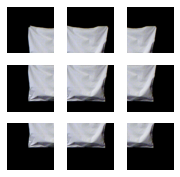

In [21]:
from matplotlib import gridspec

instance = 0
start_index = 9 * instance

plt.figure(figsize = (3,3))
gs = gridspec.GridSpec(3, 3)
gs.update(wspace=0.25, hspace=0.25) # set the spacing between axes. 

for i in range(9):
  ax1 = plt.subplot(gs[i])
  # plt.subplot(330 + i + 1)
  ax1.axis('off')
  ax1.set_aspect('equal')
  ax1.imshow(tf.cast(x[i + start_index, :, :, :3], dtype=tf.int32))

plt.show()

Next, let us examine the ground-truth normal map of this instance.

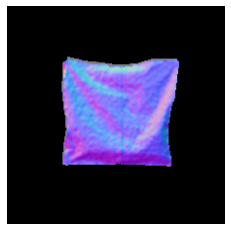

In [22]:
x, y = datagen_images.__getitem__(0)

fg_mask = x[0][:, :, 3].numpy()

normal_gt = y[0][:, :, 1:].numpy()

normal_rgb = normal_gt * 0.5 - 0.5

normal_rgb = normal_rgb * fg_mask.reshape((224, 224, 1))

plt.imshow(- normal_rgb)
plt.gca().axis('off')
plt.show()

By comparison, let us see the predicted normal map.

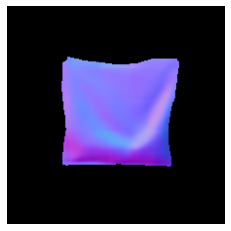

In [23]:
x, y = datagen_images.__getitem__(0)

fg_mask = x[0][:, :, 3].numpy()

_, pred_n = patchnet.forward_image(x[0][:, :, :3], x[0][:, :, 3], print_maps=False)

normal_pr = pred_n.numpy()

normal_rgb = normal_pr * 0.5 - 0.5

normal_rgb = normal_rgb * fg_mask.reshape((224, 224, 1))

plt.imshow(- normal_rgb)
plt.gca().axis('off')
plt.show()

Finally, let us see the distribution of the loss of the normal map prediction.

In [24]:
from patch.Losses import normal_loss
import numpy as np

In [25]:
x, y = datagen.__getitem__(0)
pred_depth, pred_normal = patchnet(x[:,:,:,:3])

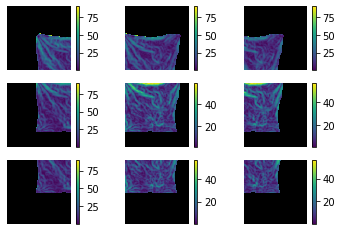

In [26]:
for i in range(9):
  normal_gt = y[i, :, :, 1:]
  normal_pr = pred_normal[i, :, :, :]

  foreground_mask = x[i, :, :, 3]

  foreground_mask_tensor = tf.reshape(foreground_mask, (patch_size, patch_size, 1))

  loss = normal_loss(normal_pr, normal_gt, foreground_mask_tensor)
  loss_tensor = normal_loss(normal_pr, normal_gt, foreground_mask_tensor, per_pixel=False)

  loss_np = tf.reshape(loss_tensor, (patch_size, patch_size)).numpy()

  loss_np[loss_np == 0] = np.nan

  normal_pr_rgb = normal_pr * 0.5 - 0.5

  normal_pr_rgb = normal_pr_rgb * foreground_mask_tensor
  

  plt.subplot(330 + i + 1)
  plt.gca().axis('off')
  plt.gca().set_facecolor((0, 0, 0))
  plt.gca().add_artist(plt.gca().patch)
  plt.gca().patch.set_zorder(-1)
  plt.imshow(loss_np / 10 * 180)
  plt.colorbar()

plt.show()